In [83]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz 
import seaborn as sns
import warnings

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.neural_network import MLPRegressor


# Pre-Modeling Analysis

In [80]:

# encoded data
df = pd.read_csv("data\\fullyEncoded.csv", header=0)

features = df.drop(["Global_Sales"], axis=1)
target = df[["Global_Sales"]]

df.head()


,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,10.0,2006.0,10.0,82.53,7.6,51.0,8.0,322.0,1.0
1,10.0,2008.0,6.0,35.52,8.2,73.0,8.3,709.0,1.0
2,10.0,2009.0,10.0,32.77,8.0,73.0,8.0,192.0,1.0
3,1.0,2006.0,4.0,29.80,8.9,65.0,8.5,431.0,1.0
4,10.0,2006.0,3.0,28.92,5.8,41.0,6.6,129.0,1.0


In [81]:

# split into test / train
features = df.drop(["Global_Sales"], axis=1)
target = df[["Global_Sales"]]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, random_state=22)


In [71]:

def y_bins(y_cols, cuts):

    labels = [f"< ${c}M" for c in cuts[1:]]
    y = pd.cut(y_cols['Global_Sales'], bins=cuts, labels=labels)

    # Plot histogram
    sns.histplot(data=y, kde=True)
    plt.title('Distribution of Global Sales')
    plt.show()

    # create bins to encode sales columns
    y_bins = {}
    for y in y_cols:
        y_bins[y] = pd.Series(pd.cut(y_cols[y], bins=cuts, labels=labels))
    return pd.DataFrame(y_bins)


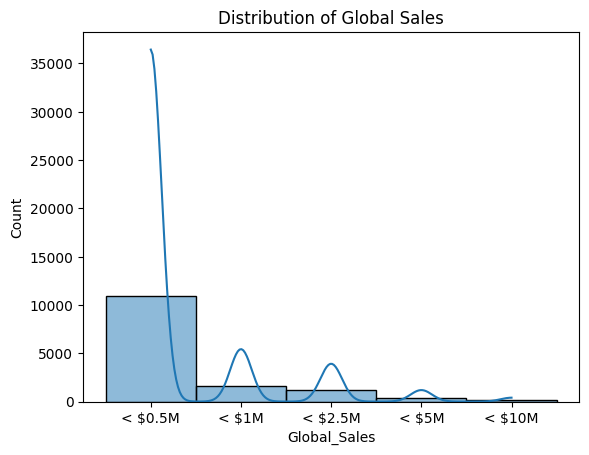

,Global_Sales
10596,< $0.5M
9634,< $0.5M
6450,< $0.5M
6379,< $0.5M
12968,< $0.5M


In [67]:

# split into feature columns and sales columns (y vars.)
sales = []
feats = []
for name in list(df.columns):
    if "Sales" in name:
        sales.append(name)
    else:
        feats.append(name)

y_cols = df[sales]
x_cols = df[feats]

cuts = [float('-inf'), 0, 0.5, 1, 2.5, 5, 10]
# cuts = [0, 1, 5, 10, 25, 50, 100]

y_col_bins = y_bins(y_cols, cuts)
x_train, x_test, y_train, y_test = train_test_split(x_cols, y_col_bins, test_size=0.2)

y_train.head()


In [72]:

for region in y_cols:
    no_sales = len(df[df[region]==0])
    r = region.split("_")[0]
    print(f'[{r}] data is {no_sales/len(df):.2%} items with no recorded sales.\n')

y_cols.describe()


[Global] data is 0.00% items with no recorded sales.



,Global_Sales
count,14259.000000
mean,0.521288
std,1.492741
min,0.010000
25%,0.060000
50%,0.160000
75%,0.460000
max,82.530000


IndexError: index 1 is out of bounds for axis 0 with size 1

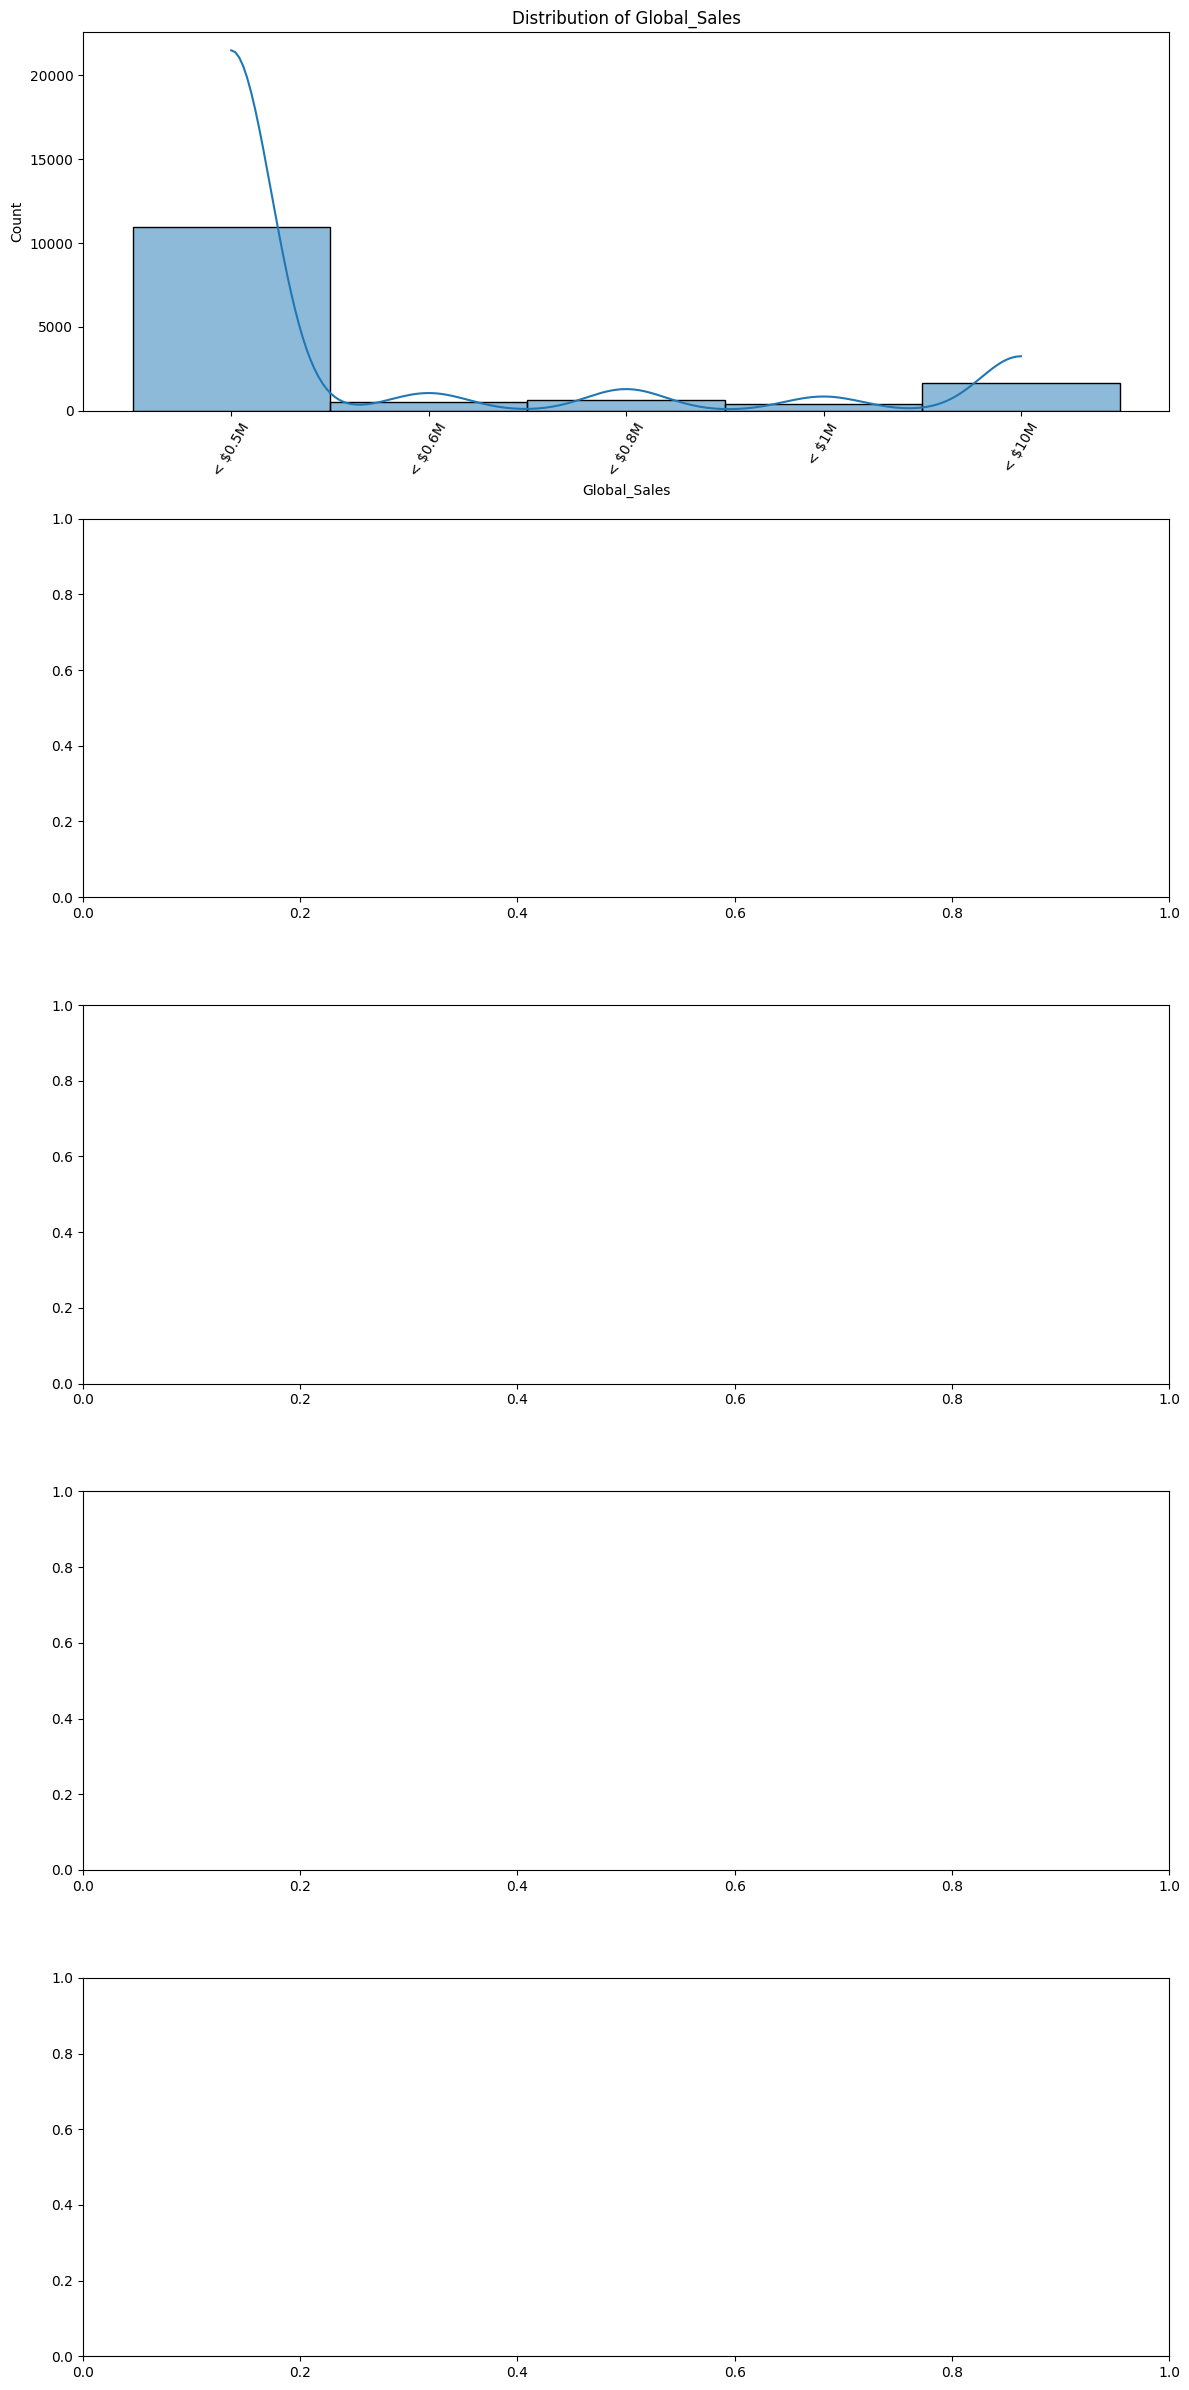

In [69]:
# split into bins
cuts = {
    'NA_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5],
    'EU_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5],
    'JP_Sales':     [float('-inf'), 0, 0.001, 0.01, 0.06, 0.5, 1, 5],
    'Other_Sales':  [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5],
    'Global_Sales': [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 1, 10]
}

y_bins = {}

# Plot the top 3 principal components with their corresponding feature names
fig, axs = plt.subplots(5, 1, figsize=(12,24))
for i in range(5):
    y = y_cols.columns[i]
    bin_labels = [f"< ${c}M" for c in cuts[y]][1:]
    y_var = pd.Series(pd.cut(y_cols[y], bins = cuts[y], labels = bin_labels))
    y_bins[y] = y_var
    
    sns.histplot(data = y_var, kde = True, ax = axs[i])
    axs[i].set_title(f'Distribution of {y}')
    plt.setp(axs[i].get_xticklabels(), rotation=60)
    plt.tight_layout()

y_col_bins = pd.DataFrame(y_bins) 

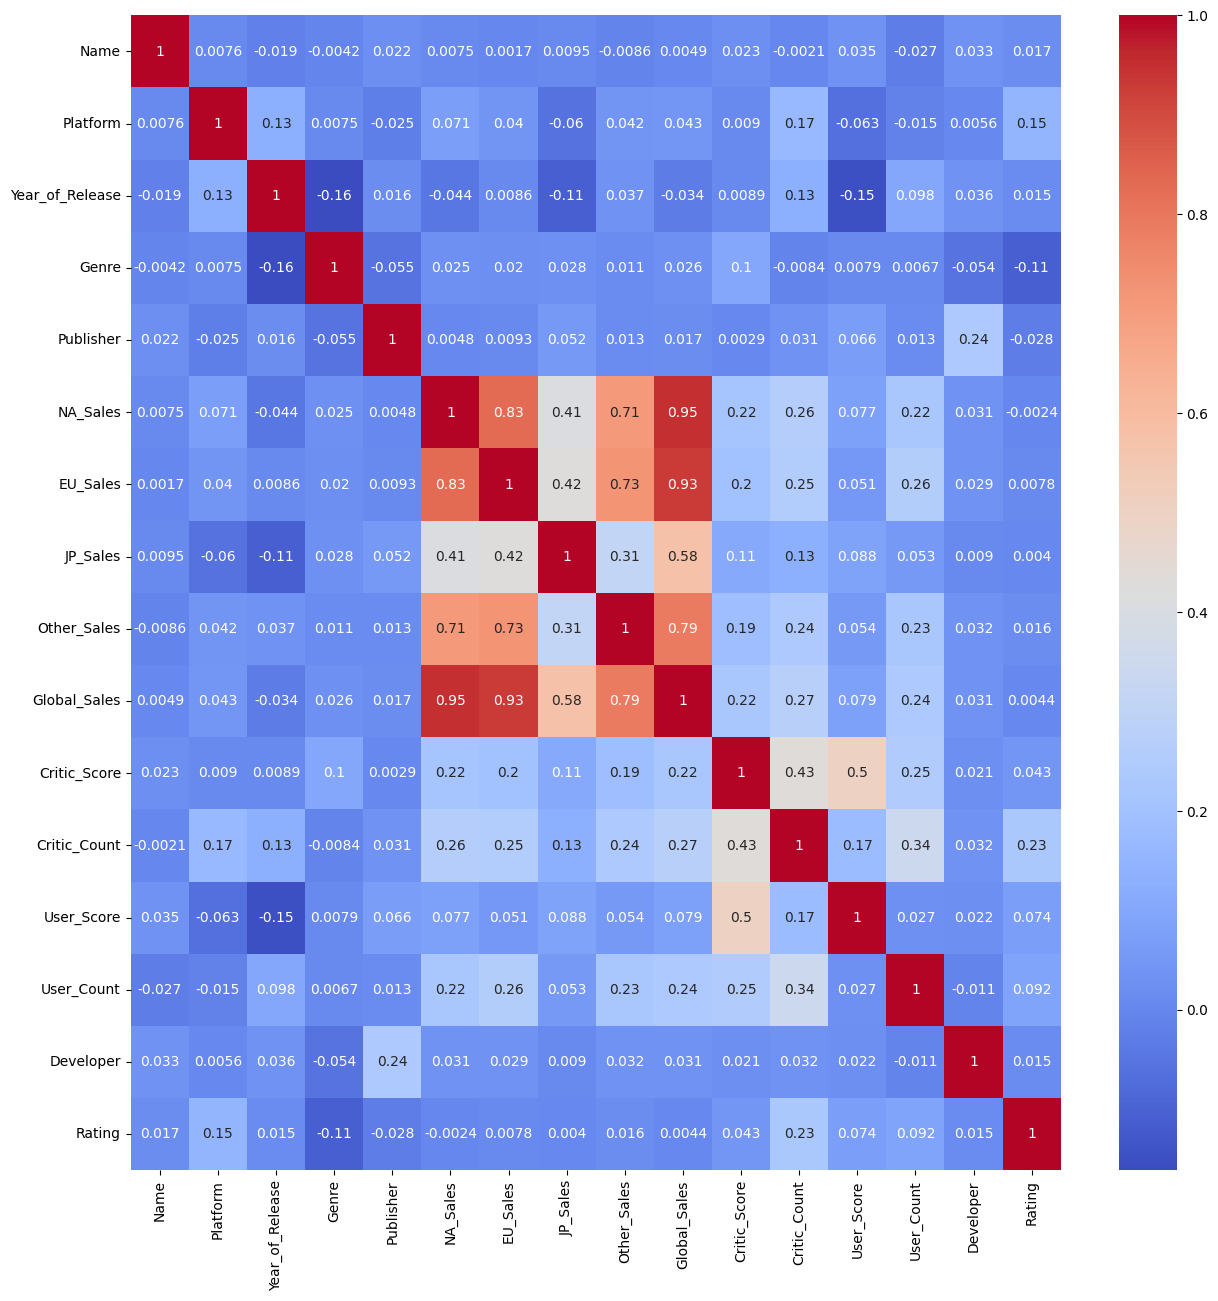

In [19]:

# cmap = sns.cubehelix_palette(start=0.5, rot=-0.3, as_cmap=True)
cmap='coolwarm'
corrmat = df.corr()
top_corr_features = corrmat.index

#plot heat map
plt.figure(figsize=(15,15))
g=sns.heatmap(df[top_corr_features].corr(),
              annot=True,
              cmap=cmap) 


# Feature Engineering

## PCA

In [63]:

# Fit PCA model with x features
pca = PCA()
pca.fit(x_cols)
# get principal components
X_pca = pca.transform(x_cols)

# Get the explained variance of PC and sort by weight
explained_var = pca.explained_variance_ratio_
importance = list(zip(x_cols.columns, explained_var))
importance.sort(key=lambda x: x[1], reverse=True)
print('Feature importance by explained variance:\n')
for i, (feat, var) in enumerate(importance):
    print(f'{i+1}. {feat}: {var:.4f}')


Feature importance by explained variance:

1. Platform: 0.5090
2. Year_of_Release: 0.4206
3. Genre: 0.0697
4. Publisher: 0.0005
5. Critic_Score: 0.0001
6. Critic_Count: 0.0000
7. User_Score: 0.0000
8. User_Count: 0.0000
9. Developer: 0.0000
10. Rating: 0.0000


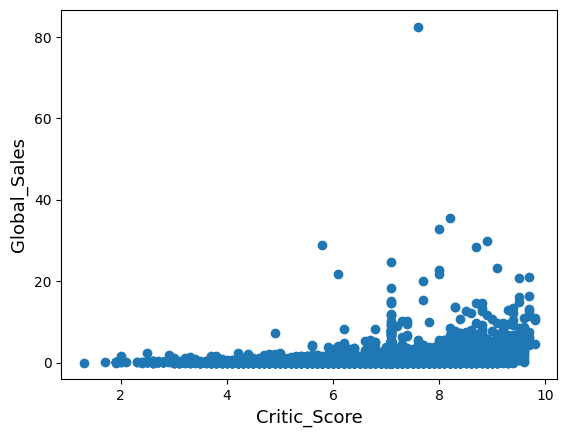

In [60]:

fig, ax = plt.subplots()
ax.scatter(x = df['Critic_Score'], y = df['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()


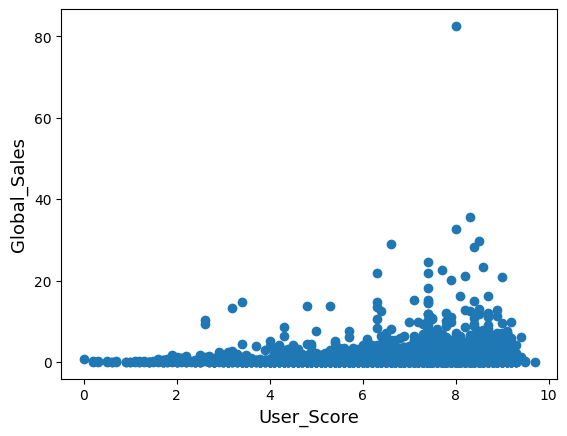

In [61]:
fig, ax = plt.subplots()
ax.scatter(x = df['User_Score'], y = df['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('User_Score', fontsize=13)
plt.show()

Platform
5.0     0.149242
1.0     0.148821
6.0     0.091636
10.0    0.090233
12.0    0.086444
8.0     0.083708
4.0     0.083497
3.0     0.066657
13.0    0.056343
0.0     0.035925
9.0     0.030101
7.0     0.027575
2.0     0.022172
14.0    0.017331
11.0    0.010314
Name: proportion, dtype: float64
Genre
0.0     0.207059
10.0    0.140331
3.0     0.107073
7.0     0.089321
1.0     0.083006
8.0     0.080059
6.0     0.074797
9.0     0.056062
2.0     0.047923
11.0    0.042029
4.0     0.039924
5.0     0.032417
Name: proportion, dtype: float64
Publisher
125.0    0.085181
19.0     0.059992
309.0    0.058939
469.0    0.058869
249.0    0.048905
           ...   
35.0     0.000070
509.0    0.000070
122.0    0.000070
185.0    0.000070
375.0    0.000070
Name: proportion, Length: 515, dtype: float64
Developer
766.0     0.374895
1449.0    0.012910
406.0     0.010385
424.0     0.010244
765.0     0.009753
            ...   
53.0      0.000070
429.0     0.000070
605.0     0.000070
1521.0    0.000070
695.0 

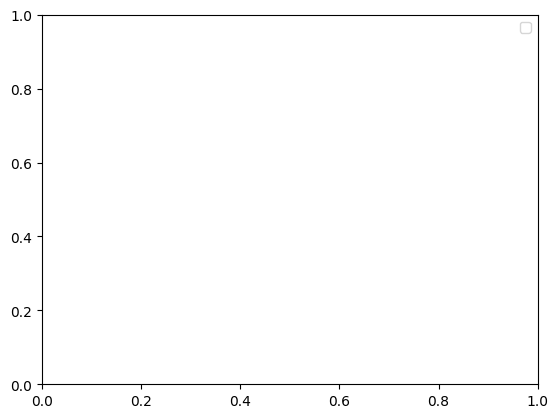

In [62]:

col_dist = [
    "Platform",
    "Genre",
    "Publisher",
    "Developer",
    "Rating"
]
for col in col_dist:
    ct = df[col].value_counts(normalize=True)
    # plt.scatter(df[col], df[col].index)
    print(ct)

plt.legend()
plt.show()

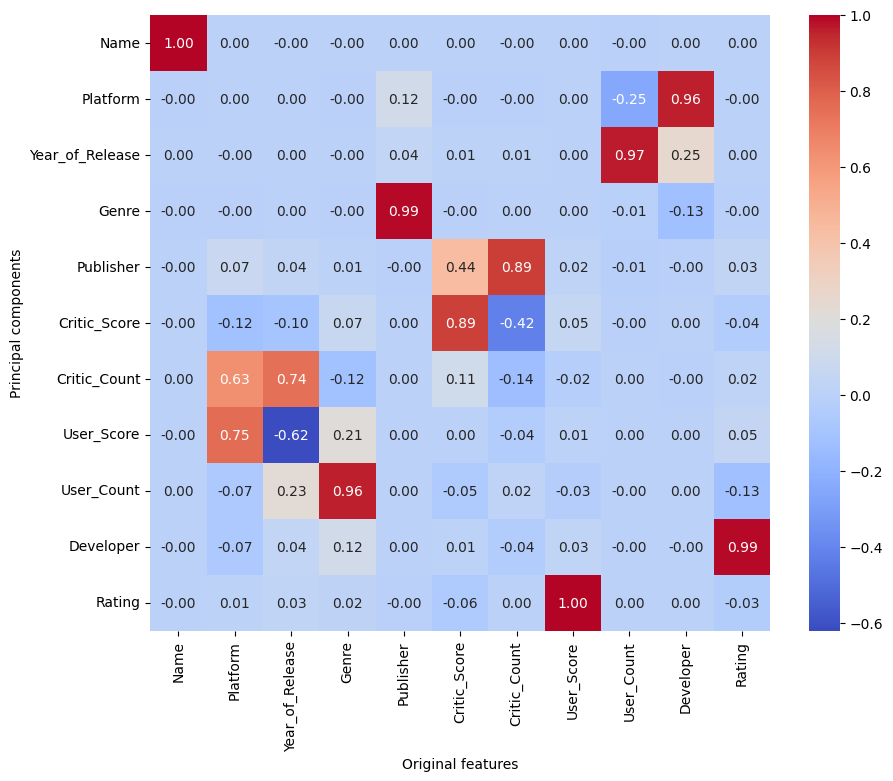

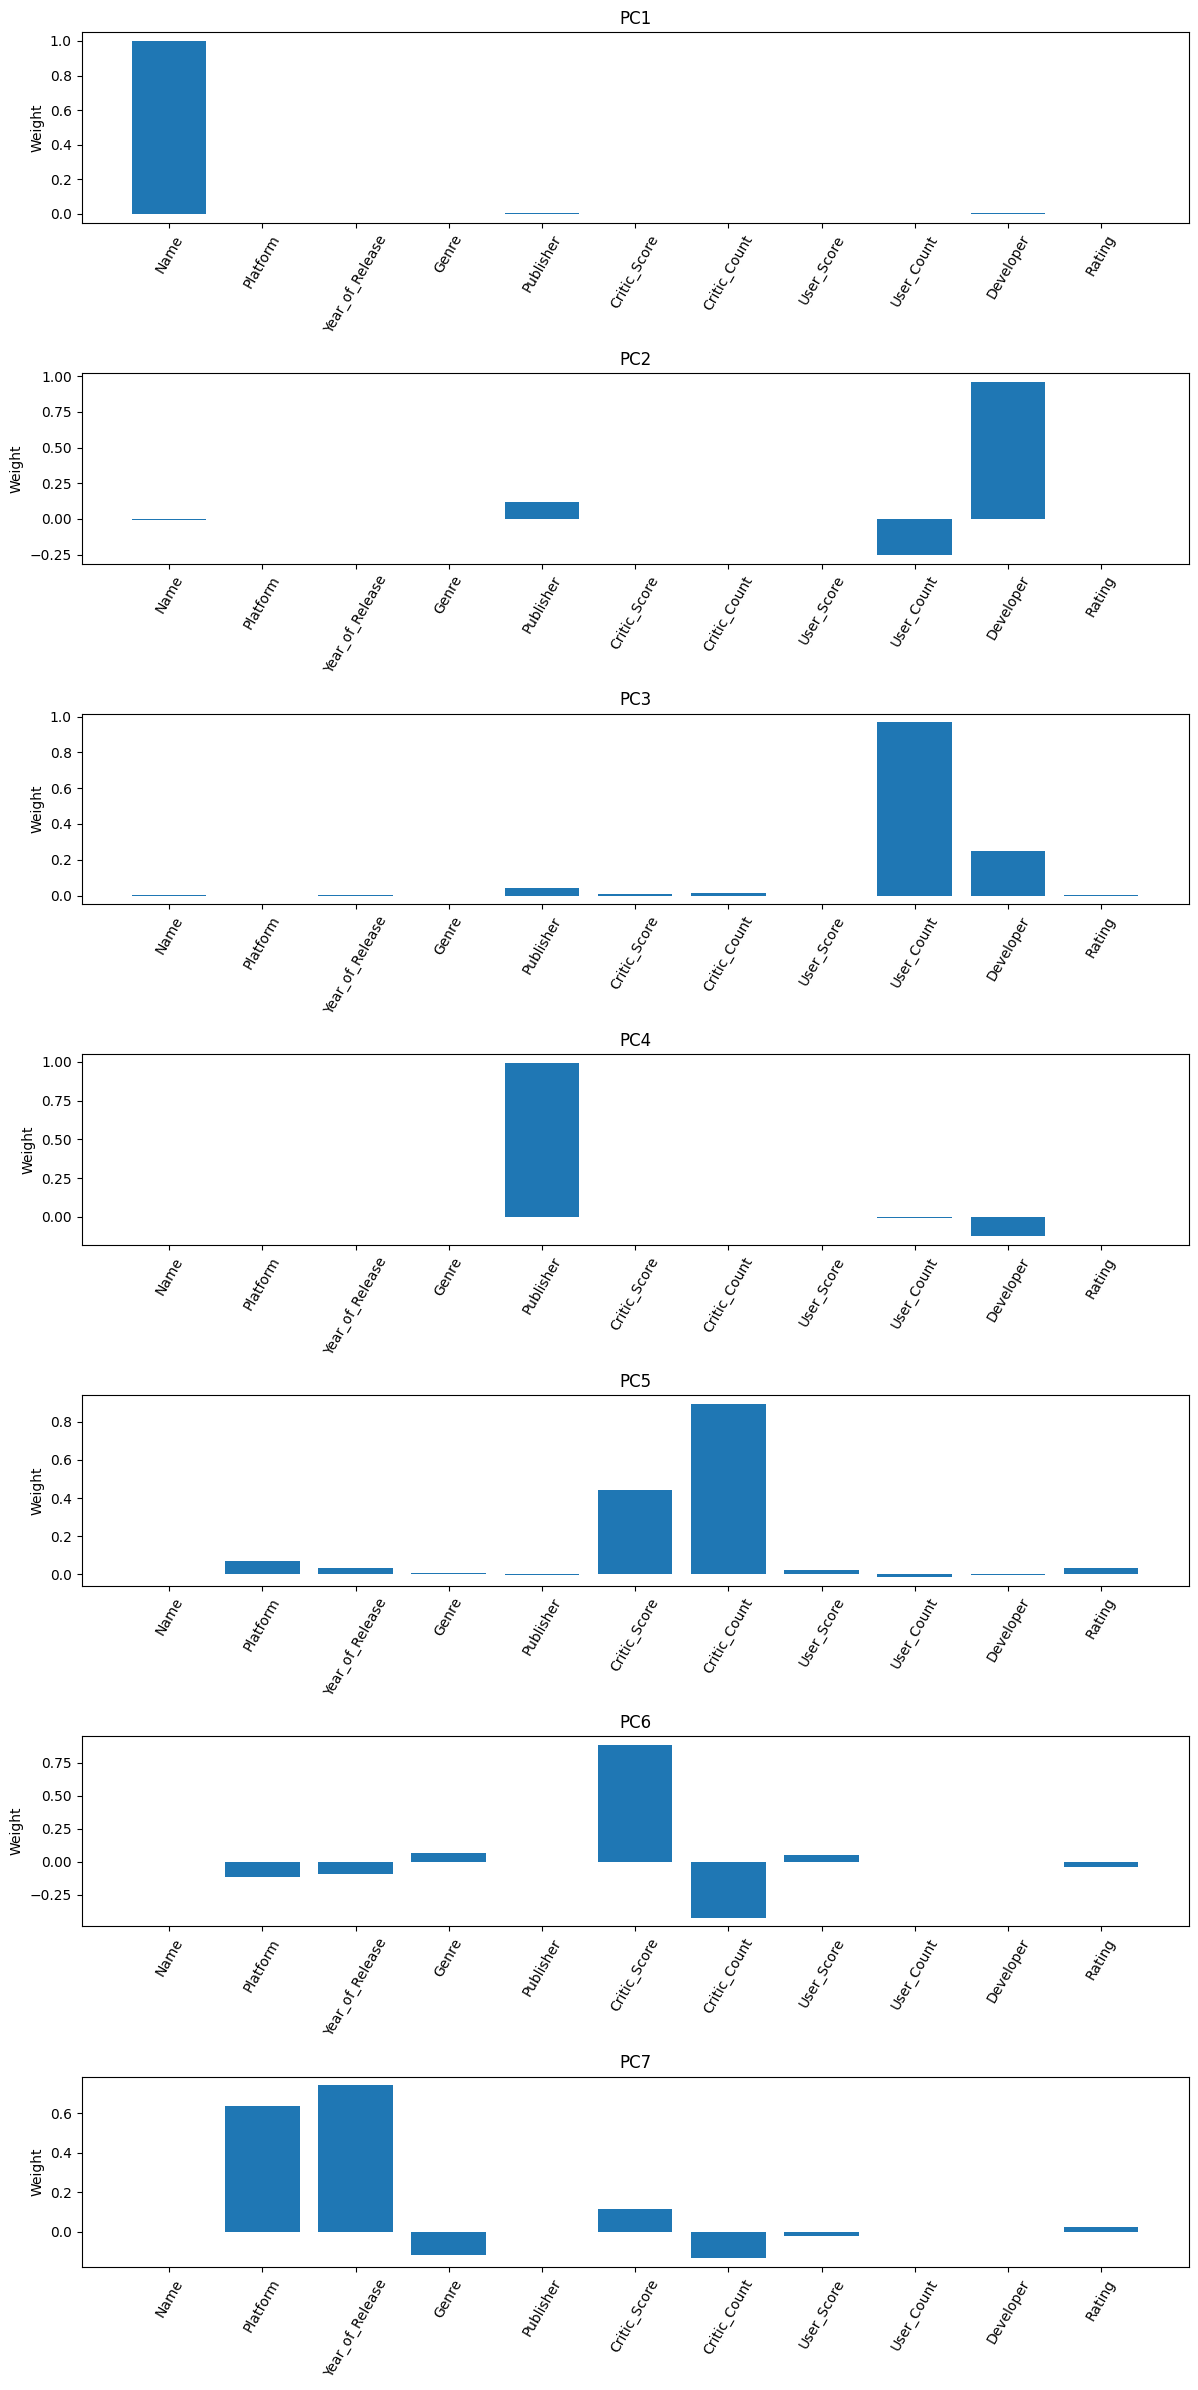

In [21]:
feats = list(zip(*importance))[0]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pca.components_, cmap=cmap,
            annot=True, fmt='.2f', 
            xticklabels=x_cols.columns,
            yticklabels=feats,
            vmax=1.0)
ax.set_xlabel('Original features')
ax.set_ylabel('Principal components')

# Get the names of the input features
feature_names = list(x_cols.columns)
n_plots = 7

# Show size of each PC vector's eigenvalues/weights
fig, axs = plt.subplots(n_plots, 1, figsize=(12, 24))
for i in range(n_plots):
    axs[i].bar(feature_names, pca.components_[i])
    axs[i].set_title(f'PC{i+1}')
    axs[i].set_ylabel('Weight')
    plt.setp(axs[i].get_xticklabels(), rotation=60)
    
plt.tight_layout()

plt.show()

# Modeling

## Decision Trees

### Decision Tree Classifier + Grid Search

In [22]:

# function to update max_leaf_nodes for DT classifier
clf = lambda x: DecisionTreeClassifier(max_leaf_nodes=x)

def build_decision_tree(max_nodes, y_test_cat, y_train_cat, view_mode=False):
    # build classifier with specified max leaf nodes
    classifier = clf(max_nodes)
    # fit classifier to training data
    classifier.fit(x_train, np.ravel(y_train_cat))
    # export tree data with feature and class labels to graph visualizer
    dot_data = tree.export_graphviz(classifier, 
                                    out_file=None, 
                                    feature_names=feats, 
                                    class_names=labels,
                                    impurity=False, filled=True, rounded=True)  
    
    # create the DT graph and render as a png
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render('decision_tree',view=view_mode)
    
    # calculate classifier score
    score = classifier.score(x_test, y_test_cat)
    y_pred = classifier.predict(x_test)
    print(f'Score: {score}\n')
    
    return score, y_pred

def grid_search(y_train):
    # initialze DT classifier
    max_nodes = None
    classifier = clf(max_nodes)
    
    # set max node range and suppress warning for small bins
    warnings.filterwarnings("ignore", category=UserWarning)
    params = {'max_leaf_nodes': list(range(3, 100))}
    
    # use grid search to get max leaf nodes hyperparameter
    grid_search = GridSearchCV(classifier, params)
    grid_search.fit(x_train, y_train)

    # update max node value
    max_nodes = grid_search.best_estimator_.get_params()["max_leaf_nodes"]
    print(f'Max. leaf nodes from grid search: {max_nodes}')
    
    return max_nodes


In [23]:

y_preds = {}

for category in y_test:
    test, train = y_test[category], y_train[category]
    cat_title = ' '.join(category.split('_'))
    print(f'{cat_title} Classification:')
    
    max_nodes = grid_search(train)
    score, prediction = build_decision_tree(max_nodes, test, train)
    y_preds[category] = (score, prediction)
      

NA Sales Classification:
Max. leaf nodes from grid search: 90


NameError: name 'labels' is not defined

#### Bins from Bayesian model

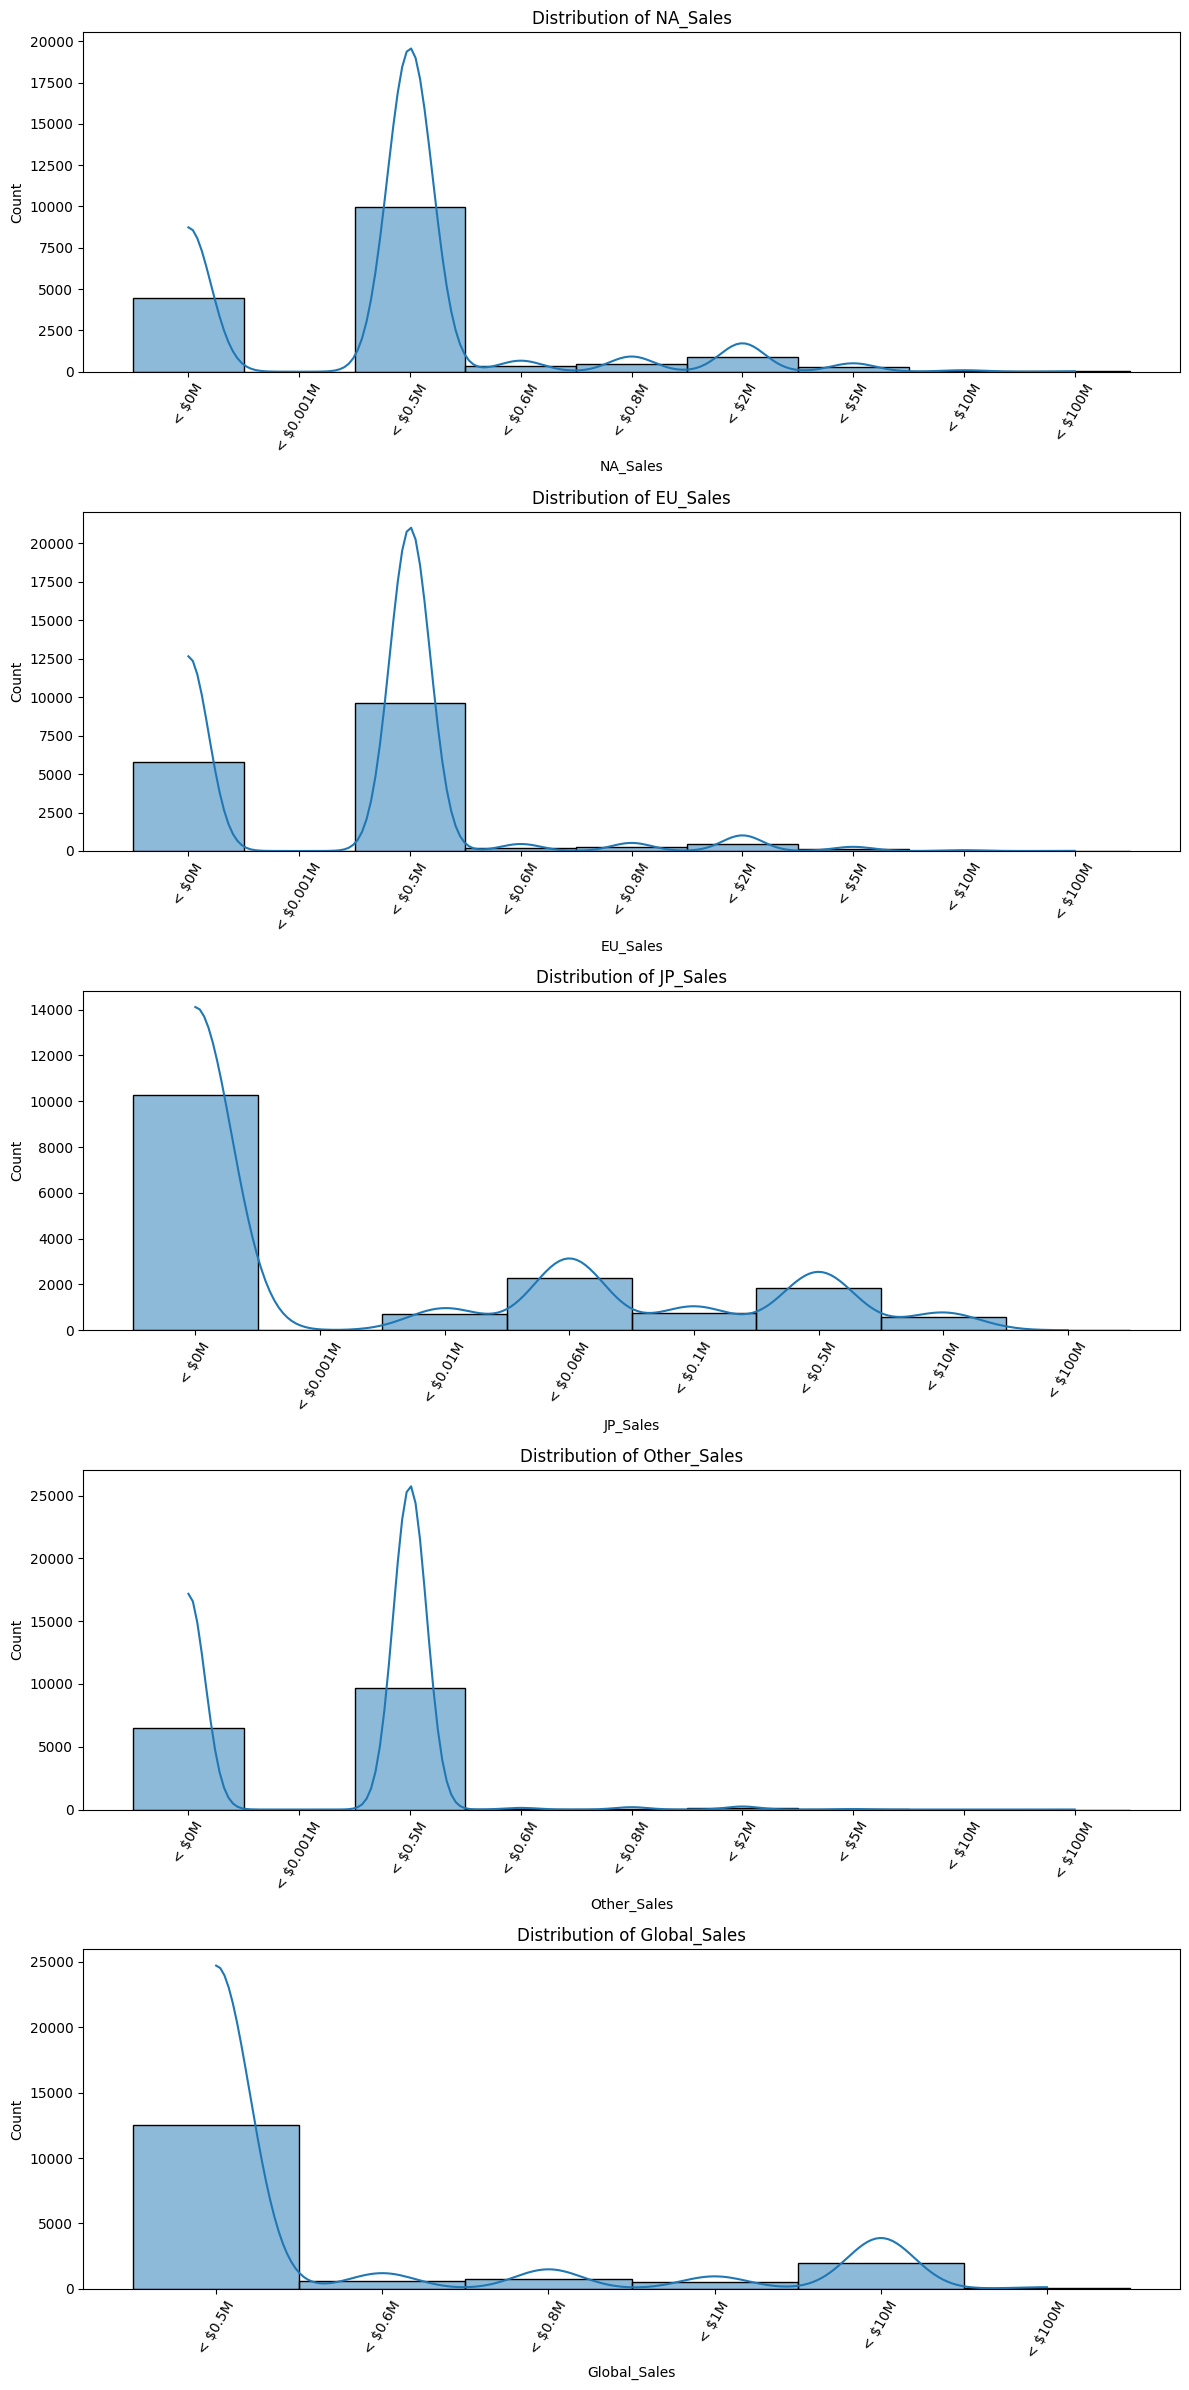

In [29]:

cuts = {
    'NA_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'EU_Sales':     [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'JP_Sales':     [float('-inf'), 0, 0.001, 0.01, 0.06, 0.1, 0.5, 10, 100],
    'Other_Sales':  [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 2, 5, 10, 100],
    'Global_Sales': [float('-inf'), 0, 0.001, 0.5, 0.6, 0.8, 1, 10, 100]
}
y_bins = {}

# Plot the distributions for each region
fig, axs = plt.subplots(5, 1, figsize=(12,24))
for i in range(5):
    y = y_cols.columns[i]
    bin_labels = [f"< ${c}M" for c in cuts[y]][1:]
    y_var = pd.Series(pd.cut(y_cols[y], bins=cuts[y], labels=bin_labels))
    y_bins[y] = y_var
    
    sns.histplot(data=y_var, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {y}')
    plt.setp(axs[i].get_xticklabels(), rotation=60)
    plt.tight_layout()

y_col_bins = pd.DataFrame(y_bins) 


In [30]:

x_train, x_test, y_train, y_test = train_test_split(x_cols, y_col_bins, test_size=0.2)


In [31]:

y_preds = {}
for category in y_test:
    test, train = y_test[category], y_train[category]
    cat_title = ' '.join(category.split('_'))
    print(f'{cat_title} Classification:')
    
    max_nodes = grid_search(train)
    score, prediction = build_decision_tree(max_nodes, test, train)
    y_preds[category] = (score, prediction)
    

NA Sales Classification:
Max. leaf nodes from grid search: 97
Score: 0.7743605359317906

EU Sales Classification:
Max. leaf nodes from grid search: 76
Score: 0.7448233861144945

JP Sales Classification:
Max. leaf nodes from grid search: 97
Score: 0.6982338611449452

Other Sales Classification:
Max. leaf nodes from grid search: 72
Score: 0.7700974421437271

Global Sales Classification:
Max. leaf nodes from grid search: 55
Score: 0.807551766138855



### Random Forest DT

In [82]:

max_nodes = 50
classifier = RandomForestClassifier(n_estimators=50, max_leaf_nodes=max_nodes)
classifier.fit(x_train, y_train)

RF_pred = classifier.predict(x_test)
score = classifier.score(x_test, y_test)

print(f"Score: {score}")


ValueError: Input contains NaN

In [ ]:

random_Global = RandomForestClassifier(max_leaf_nodes = 120, n_estimators = 50)
random_Global.fit(x_train, y_train.values.ravel())
Global_prediction = random_Global.predict(x_test)
print(random_Global.score(x_test,y_test))

#global sales
bin_sales_Global = [float('-inf'),0, 0.001, 0.5,0.6,0.8,2,5,10,100]
bin_labels = [f"< ${c}M" for c in bin_sales_Global][1:] 

y_Global_test = pd.Series(y_test, name = "Global Sales")
y_Global_p = pd.Series(Global_prediction, name = "prediction")

plt.figure("Global Sales")
sns.set(rc={"figure.figsize":(12, 5)})
sns.histplot(data = y_Global_test,  fill=False, color = 'red', lw=2.5, stat = "count", label = "test data")
sns.histplot(data = y_Global_p,  fill=False, stat = "count", lw=2.5, label = "predictions")
plt.legend()


## Naive Bayes

In [ ]:

def nb_modeling(x_cols, y_col_bins):
    # separate into test and train data
    x_train, x_test, y_train, y_test = train_test_split(x_cols, y_col_bins, test_size=0.2, random_state=0)
    # store model scores for comparison
    scores = {y:{'Categorical':float, 'Gaussian':float} for y in y_cols}

    # predict bins with Categorical Naive Bayes
    print('Categorical Naive Bayes')
    clf = CategoricalNB()
    for y in y_cols: 
        clf.fit(x_train, y_train[y])
        clf.predict(x_test)
        
        score = clf.score(x_test,y_test[y])
        scores[y]['Categorical'] = score
        
        print(f"{y} Score: {score}")  

    print('\n')
    # predict bins with Gaussian Naive Bayes
    print('Gaussian Naive Bayes')
    clf = GaussianNB()
    for y in y_cols: 
        clf.fit(x_train, y_train[y])
        clf.predict(x_test)
        
        score = clf.score(x_test,y_test[y])
        scores[y]['Gaussian'] = score
        
        print(f"{y} Score: {score}")  

    print('\n')
    for cat in scores:
        gauss = scores[cat]['Gaussian']
        cate = scores[cat]['Categorical']
        diff = gauss - cate

        if diff > 0:
            print(f'{cat} scored {diff:.2%} higher with Gaussian NB.')

        else:
            print(f'{cat} scored {-diff:.2%} higher with Categorical NB.')
        
nb_modeling(x_cols, y_col_bins)        

## Logistic Regression

In [ ]:

def get_threshold(sale_list):
    threshold = []
    for i in range(sale_list.shape[1]):
        threshold.append(sale_list.iloc[:,i].mean())
    return threshold

def trans_bisec(sale_list, threshold):
    for i in range(sale_list.shape[0]):
        if sale_list.iloc[i] >= threshold:
            sale_list.iloc[i] = 1
        else:
            sale_list.iloc[i] = 0
    return sale_list

def evaluate(y_pred, y_test):
    count = 0
    correct = 0
    for i in range(y_pred.size):
        if y_pred[i] == y_test.iloc[i]:
            correct += 1
        count += 1
    return correct / count

threshold = get_threshold(y_train)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, trans_bisec(y_train, threshold[i]))
y_pred = clf.predict(X_test)
accuracy = evaluate(y_pred, trans_bisec(y_test, threshold[i]))
print(f'The accuracy of Global Sales prediction is: {accuracy}')


## Linear Regression

In [ ]:
clf = LinearRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Coefficients: \n", clf.coef_)
print("Mean squared error of NA Sales: %.2f" % mean_squared_error(y_test['NA_Sales'], y_pred[:,0]))
print("Mean squared error of EU Sales: %.2f" % mean_squared_error(y_test['EU_Sales'], y_pred[:,1]))
print("Mean squared error of JP Sales: %.2f" % mean_squared_error(y_test['JP_Sales'], y_pred[:,2]))
print("Mean squared error of Ohter Sales: %.2f" % mean_squared_error(y_test['Other_Sales'], y_pred[:,3]))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print(clf.score(X_test, y_test))

In [ ]:
# How to visualize multiple regression? (with more than 2 input attrs)
fig, ax = plt.subplot()
x1 = np.linspace(0, 1, 1642)
x2 = np.linspace(0, 1, 1642)
ax.plot(x1, y_pred[:,0], label = 'predict')
ax.plot(x2, y_test['Global_Sales'], label = 'test')
plt.show()

## Artificial Neural Network

In [ ]:
# After testing, applying StandardScaler() to X make the predict result
# much more accurate.
# It increses the score 20-75 times, and lower the MSE 50-100 times.
Xs = StandardScaler()
Xs.fit(X_train)
X_train = Xs.transform(X_train)
X_test = Xs.transform(X_test)

clf_NA = MLPRegressor(hidden_layer_sizes=(150, 100, 50),  
                      activation='relu', solver='adam', alpha=1e-4, batch_size='auto',learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,random_state=42)
clf_EU = MLPRegressor(hidden_layer_sizes=(150, 100, 50),  
                      activation='relu', solver='adam', alpha=1e-4, batch_size='auto',learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,random_state=42)
clf_JP = MLPRegressor(hidden_layer_sizes=(150, 100, 50),  
                      activation='relu', solver='adam', alpha=1e-4, batch_size='auto',learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,random_state=42)
clf_Other = MLPRegressor(hidden_layer_sizes=(150, 100, 50),  
                         activation='relu', solver='adam', alpha=1e-4, batch_size='auto',learning_rate_init=0.001, power_t=0.5, max_iter=5000, shuffle=True,random_state=42)

clf_NA.fit(X_train, y_train['NA_Sales'])
clf_EU.fit(X_train, y_train['EU_Sales'])
clf_JP.fit(X_train, y_train['JP_Sales'])
clf_Other.fit(X_train, y_train['Other_Sales'])

NA_pred = clf_NA.predict(X_test)
EU_pred = clf_EU.predict(X_test)
JP_pred = clf_JP.predict(X_test)
Other_pred = clf_Other.predict(X_test)

NA_score = clf_NA.score(X_test, y_test['NA_Sales'])
EU_score = clf_EU.score(X_test, y_test['EU_Sales'])
JP_score = clf_JP.score(X_test, y_test['JP_Sales'])
Other_score = clf_Other.score(X_test, y_test['Other_Sales'])

mse_NA = mean_squared_error(NA_pred, y_test['NA_Sales'])
mse_EU = mean_squared_error(EU_pred, y_test['EU_Sales'])
mse_JP = mean_squared_error(JP_pred, y_test['JP_Sales'])
mse_Other = mean_squared_error(Other_pred, y_test['Other_Sales'])

print("Score of NA is:", NA_score)
print("MSE of NA is:", mse_NA)
print("Score of EU is:", EU_score)
print("MSE of EU is:", mse_EU)
print("Score of JP is:", JP_score)
print("MSE of JP is:", mse_JP)
print("Score of Other is:", Other_score)
print("MSE of Other is:", mse_Other)


### Tune the parameters using grid search
### For the time effiency, using adam for solver and 5000 for max iteration

In [ ]:

param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05]
}
grid_NA = GridSearchCV(clf_NA, param_grid, n_jobs=-1, cv=5)
grid_NA.fit(X_train, y_train['NA_Sales'])
grid_EU = GridSearchCV(clf_EU, param_grid, n_jobs=-1, cv=5)
grid_EU.fit(X_train, y_train['EU_Sales'])
grid_JP = GridSearchCV(clf_JP, param_grid, n_jobs=-1, cv=5)
grid_JP.fit(X_train, y_train['JP_Sales'])
grid_Other = GridSearchCV(clf_Other, param_grid, n_jobs=-1, cv=5)
grid_Other.fit(X_train, y_train['Other_Sales'])

print('Best parameters for NA:', grid_NA.best_params_)
print('Best parameters for EU:', grid_EU.best_params_)
print('Best parameters for JP:', grid_JP.best_params_)
print('Best parameters for Other:', grid_Other.best_params_)

# predictions after grid search tuning
NA_pred_grid = grid_NA.predict(X_test)
mse_NA_grid = mean_squared_error(NA_pred_grid, y_test['NA_Sales'])
EU_pred_grid = grid_EU.predict(X_test)
mse_EU_grid = mean_squared_error(EU_pred_grid, y_test['EU_Sales'])
JP_pred_grid = grid_JP.predict(X_test)
mse_JP_grid = mean_squared_error(JP_pred_grid, y_test['JP_Sales'])
Other_pred_grid = grid_Other.predict(X_test)
mse_Other_grid = mean_squared_error(Other_pred_grid, y_test['Other_Sales'])

print('Score for NA after grid search:', grid_NA.best_score_)
print('MSE for NA after grid search:', mse_NA_grid)
print('Score for EU after grid search:', grid_EU.best_score_)
print('MSE for EU after grid search:', mse_EU_grid)
print('Score for JP after grid search:', grid_JP.best_score_)
print('MSE for JP after grid search:', mse_JP_grid)
print('Score for Other after grid search:', grid_Other.best_score_)
print('MSE for Other after grid search:', mse_Other_grid)


## SVM

In [ ]:
RegModel = svm.SVR(C=4, kernel='rbf')
SVM=RegModel.fit(x_train, y_train)
prediction_Global=SVM.predict(x_test)
Global_error = mean_squared_error(y_test, prediction_Global)